In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
import ast

import shap
import optuna as optuna
from sklearn import metrics

import optuna

from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from catboost.utils import get_gpu_device_count
from sklearn.metrics import roc_auc_score

import joblib

In [2]:
train = pd.read_csv("D:/educ/ml/hack/bank-churn-competition-by-ipii-hs-ex-mts/train.csv", sep=',')
test = pd.read_csv("D:/educ/ml/hack/bank-churn-competition-by-ipii-hs-ex-mts/test.csv", sep=',')

In [3]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15752626.0,Martin,675.0,France,Female,48.0,7.0,143582.89,2.0,0.0,0.0,93844.82,1.0
1,1,15797960.0,Pagnotto,673.0,France,Female,37.0,7.0,0.00,2.0,0.0,0.0,170980.86,0.0
2,2,15672056.0,T'an,607.0,France,Male,29.0,4.0,0.00,2.0,0.0,1.0,61290.99,0.0
3,3,15733169.0,Chukwufumnanya,669.0,France,Female,28.0,2.0,0.00,2.0,1.0,0.0,97734.30,0.0
4,4,15795519.0,Hsing,743.0,France,Male,24.0,7.0,0.00,2.0,1.0,0.0,180800.42,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


In [6]:
is_gpu_available = get_gpu_device_count()
device = 'GPU' if is_gpu_available else 'CPU'

device

'GPU'

In [27]:
train['HasCrCard'] = train['HasCrCard'].astype('int8')
train['IsActiveMember'] = train['IsActiveMember'].astype('int8')

In [15]:
num_cols = train.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('id')
num_cols.remove('CustomerId')

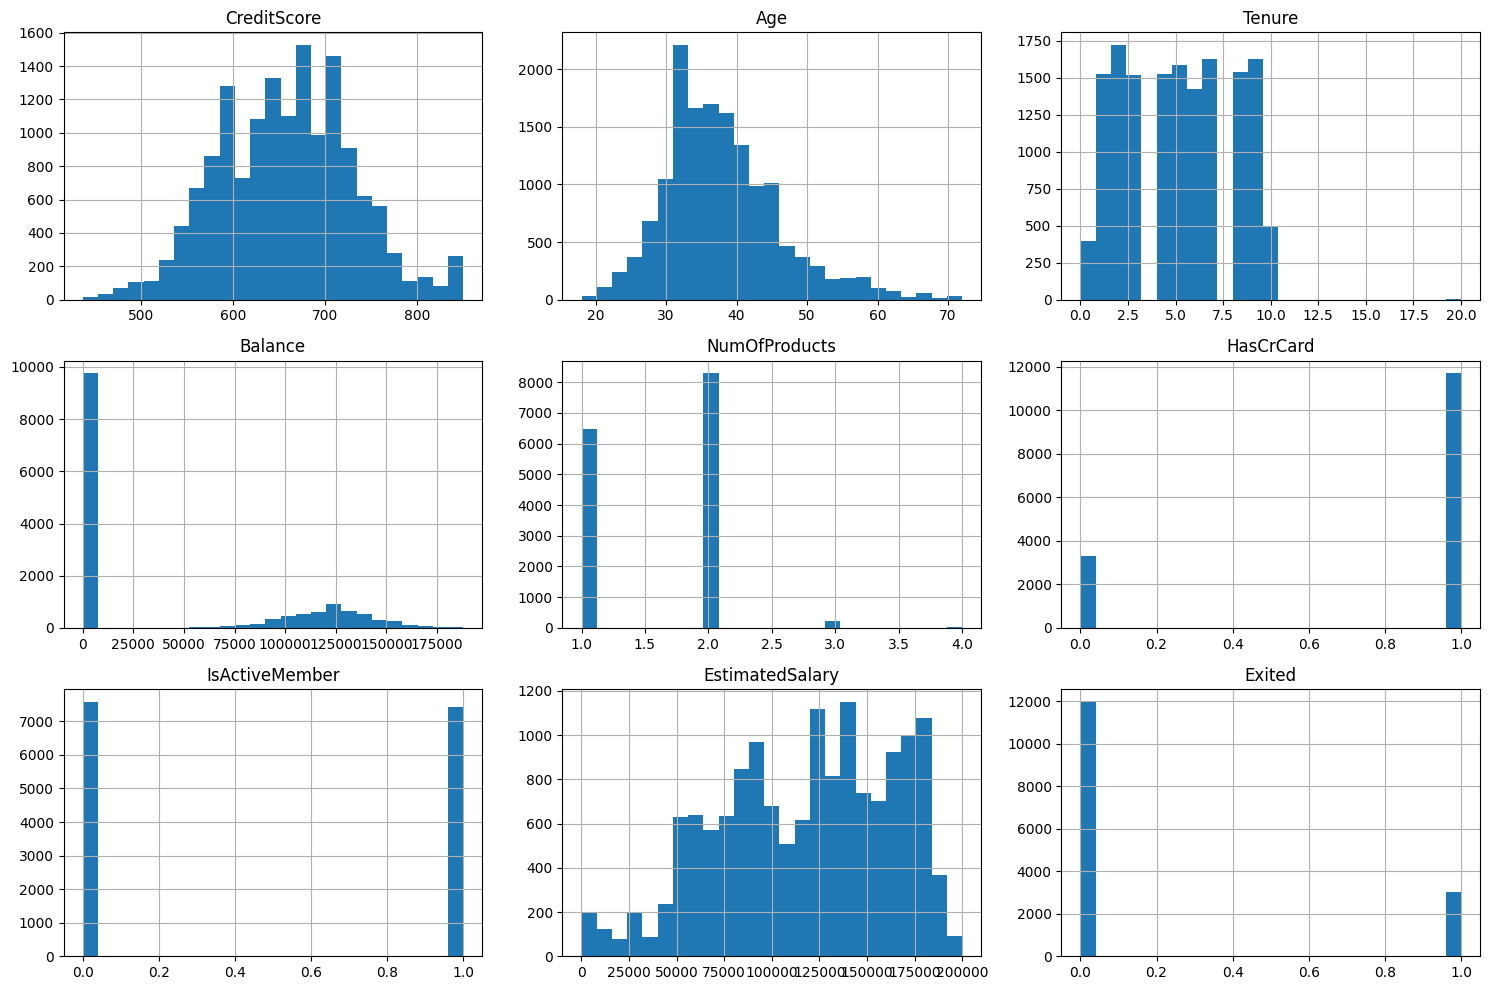

In [28]:
train[num_cols].hist(bins=25, figsize=(15,10))
plt.tight_layout()
plt.show()

In [18]:
nan_counts = train.isna().sum()
print(nan_counts)

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [30]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15752626.0,Martin,675.0,France,Female,48.0,7.0,143582.89,2.0,0,0,93844.82,1.0
1,1,15797960.0,Pagnotto,673.0,France,Female,37.0,7.0,0.00,2.0,0,0,170980.86,0.0
2,2,15672056.0,T'an,607.0,France,Male,29.0,4.0,0.00,2.0,0,1,61290.99,0.0
3,3,15733169.0,Chukwufumnanya,669.0,France,Female,28.0,2.0,0.00,2.0,1,0,97734.30,0.0
4,4,15795519.0,Hsing,743.0,France,Male,24.0,7.0,0.00,2.0,1,0,180800.42,0.0


In [ ]:
cat_features = ['Surname',
                'Geography',
                'Gender', 
                'HasCrCard', 
                'IsActiveMember'
                ]

target = ['Exited']

features2drop = ['id', 
                 'CustomerId'
                 
                 ]

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in target and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", target)

cat_features ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_features 6
targets ['Exited']


In [31]:
X = train[filtered_features].drop(target, axis=1, errors="ignore")
y = train["Exited"]

In [32]:
y.value_counts(normalize = True)

Exited
0.0    0.798867
1.0    0.201133
Name: proportion, dtype: float64

Подбор ГП

In [115]:
def objective(trial):
    
    #bootstrap_type = trial.suggest_categorical("bootstrap_type", [
        #"Bayesian", 
        #"Bernoulli", 
    #    "MVS"])

    params = {
        "iterations": 2000,
        "depth": 6,
        "learning_rate": trial.suggest_float("learning_rate", 0.06, 0.08, log=False),
        "l2_leaf_reg": 18,
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 200),        
        "bootstrap_type": 'MVS',
        "random_strength": 0.15,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 100,
        "random_seed": 42,
        "task_type": "GPU"
    }

    #if bootstrap_type == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 1.0)

    #if bootstrap_type == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)

    # Стратифицированная кросс-валидация
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)

        preds = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, preds)
        scores.append(score)

    return np.mean(scores)

In [116]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Лучшие параметры
print("Best parameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

[I 2025-06-27 22:54:24,358] A new study created in memory with name: no-name-9182f666-3a5b-4e43-9ab1-00e18dfb535d
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 60.7ms	remaining: 2m 1s
100:	test: 0.9366929	best: 0.9367185 (97)	total: 5.65s	remaining: 1m 46s
200:	test: 0.9382836	best: 0.9382988 (192)	total: 9.97s	remaining: 1m 29s
300:	test: 0.9384349	best: 0.9384860 (275)	total: 14.1s	remaining: 1m 19s
400:	test: 0.9384397	best: 0.9384950 (341)	total: 19.3s	remaining: 1m 17s
bestTest = 0.9384950399
bestIteration = 341
Shrink model to first 342 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 63.4ms	remaining: 2m 6s
100:	test: 0.9300345	best: 0.9300801 (98)	total: 5.1s	remaining: 1m 35s
200:	test: 0.9320390	best: 0.9320390 (200)	total: 10.2s	remaining: 1m 31s
300:	test: 0.9327715	best: 0.9327750 (299)	total: 16.1s	remaining: 1m 30s
400:	test: 0.9331792	best: 0.9331986 (397)	total: 23.3s	remaining: 1m 32s
500:	test: 0.9332946	best: 0.9333713 (446)	total: 30.1s	remaining: 1m 29s
bestTest = 0.9333713055
bestIteration = 446
Shrink model to first 447 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 65.2ms	remaining: 2m 10s
100:	test: 0.9333267	best: 0.9333619 (99)	total: 6.36s	remaining: 1m 59s
200:	test: 0.9341694	best: 0.9341908 (197)	total: 11.1s	remaining: 1m 39s
300:	test: 0.9344932	best: 0.9344932 (300)	total: 16.4s	remaining: 1m 32s
400:	test: 0.9343133	best: 0.9344932 (300)	total: 21.6s	remaining: 1m 26s
bestTest = 0.9344931841
bestIteration = 300
Shrink model to first 301 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 78.1ms	remaining: 2m 36s
100:	test: 0.9326003	best: 0.9326003 (100)	total: 5.41s	remaining: 1m 41s
200:	test: 0.9349726	best: 0.9349726 (199)	total: 10.4s	remaining: 1m 33s
300:	test: 0.9353967	best: 0.9355711 (274)	total: 14.7s	remaining: 1m 23s
bestTest = 0.9355710745
bestIteration = 274
Shrink model to first 275 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 61.7ms	remaining: 2m 3s
100:	test: 0.9365743	best: 0.9365916 (99)	total: 6.3s	remaining: 1m 58s
200:	test: 0.9379227	best: 0.9380673 (184)	total: 12.2s	remaining: 1m 49s
300:	test: 0.9383413	best: 0.9383489 (294)	total: 17.8s	remaining: 1m 40s
400:	test: 0.9392808	best: 0.9392905 (399)	total: 22.5s	remaining: 1m 29s
500:	test: 0.9392386	best: 0.9393306 (420)	total: 27.3s	remaining: 1m 21s


[I 2025-06-27 22:56:29,951] Trial 0 finished with value: 0.9362207150642223 and parameters: {'learning_rate': 0.07694774951239733, 'max_bin': 269, 'min_data_in_leaf': 149}. Best is trial 0 with value: 0.9362207150642223.


bestTest = 0.9393305779
bestIteration = 420
Shrink model to first 421 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 57.6ms	remaining: 1m 55s
100:	test: 0.9369023	best: 0.9369023 (100)	total: 5.21s	remaining: 1m 38s
200:	test: 0.9380735	best: 0.9381606 (191)	total: 10.9s	remaining: 1m 37s
300:	test: 0.9386477	best: 0.9386678 (295)	total: 15.1s	remaining: 1m 25s
400:	test: 0.9387742	best: 0.9389539 (362)	total: 21.6s	remaining: 1m 26s
bestTest = 0.9389538765
bestIteration = 362
Shrink model to first 363 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 61.1ms	remaining: 2m 2s
100:	test: 0.9288073	best: 0.9288736 (94)	total: 5.33s	remaining: 1m 40s
200:	test: 0.9312851	best: 0.9312851 (200)	total: 9.88s	remaining: 1m 28s
300:	test: 0.9322311	best: 0.9322311 (299)	total: 13.7s	remaining: 1m 17s
400:	test: 0.9324765	best: 0.9325670 (387)	total: 17.8s	remaining: 1m 10s
500:	test: 0.9326713	best: 0.9327508 (477)	total: 21.7s	remaining: 1m 5s
600:	test: 0.9327369	best: 0.9327701 (570)	total: 25.8s	remaining: 1m
700:	test: 0.9328517	best: 0.9328765 (697)	total: 30.7s	remaining: 56.9s
800:	test: 0.9328731	best: 0.9328938 (720)	total: 35.5s	remaining: 53.1s
900:	test: 0.9331032	best: 0.9331067 (884)	total: 39.9s	remaining: 48.6s
1000:	test: 0.9331433	best: 0.9331453 (997)	total: 43.9s	remaining: 43.8s
1100:	test: 0.9330894	best: 0.9331495 (1051)	total: 48.1s	remaining: 39.3s
1200:	test: 0.9330071	best: 0.9331613 (1107)	total: 52.6s	remaining: 35s
bestTest = 0.9331612587
bestIteration = 1107
Shrink

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 65.5ms	remaining: 2m 10s
100:	test: 0.9320800	best: 0.9320800 (98)	total: 4.83s	remaining: 1m 30s
200:	test: 0.9333813	best: 0.9334263 (198)	total: 8.78s	remaining: 1m 18s
300:	test: 0.9345831	best: 0.9345949 (287)	total: 13.1s	remaining: 1m 14s
400:	test: 0.9348481	best: 0.9348550 (383)	total: 17.6s	remaining: 1m 10s
500:	test: 0.9346896	best: 0.9348854 (402)	total: 21.7s	remaining: 1m 4s
bestTest = 0.9348854423
bestIteration = 402
Shrink model to first 403 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 58.8ms	remaining: 1m 57s
100:	test: 0.9331772	best: 0.9331772 (100)	total: 4.75s	remaining: 1m 29s
200:	test: 0.9351878	best: 0.9351878 (200)	total: 9.2s	remaining: 1m 22s
300:	test: 0.9355406	best: 0.9356465 (297)	total: 13.7s	remaining: 1m 17s
400:	test: 0.9357744	best: 0.9357980 (397)	total: 17.9s	remaining: 1m 11s
500:	test: 0.9361744	best: 0.9362429 (492)	total: 21.9s	remaining: 1m 5s
600:	test: 0.9362373	best: 0.9362442 (594)	total: 25.8s	remaining: 1m
700:	test: 0.9363847	best: 0.9363847 (700)	total: 30.1s	remaining: 55.8s
800:	test: 0.9363003	best: 0.9364677 (738)	total: 34.2s	remaining: 51.2s
bestTest = 0.9364677072
bestIteration = 738
Shrink model to first 739 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 57.1ms	remaining: 1m 54s
100:	test: 0.9361377	best: 0.9361453 (98)	total: 4.58s	remaining: 1m 26s
200:	test: 0.9374176	best: 0.9375899 (188)	total: 8.78s	remaining: 1m 18s
300:	test: 0.9387557	best: 0.9387930 (294)	total: 13.1s	remaining: 1m 13s
400:	test: 0.9392995	best: 0.9392995 (400)	total: 17.4s	remaining: 1m 9s
500:	test: 0.9395022	best: 0.9395022 (500)	total: 22s	remaining: 1m 5s
600:	test: 0.9396731	best: 0.9397063 (597)	total: 26.1s	remaining: 1m
700:	test: 0.9393977	best: 0.9397104 (623)	total: 30.3s	remaining: 56.2s


[I 2025-06-27 22:59:18,517] Trial 1 finished with value: 0.936635733534952 and parameters: {'learning_rate': 0.07213941470892607, 'max_bin': 220, 'min_data_in_leaf': 131}. Best is trial 1 with value: 0.936635733534952.


bestTest = 0.9397104383
bestIteration = 623
Shrink model to first 624 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 59.5ms	remaining: 1m 58s
100:	test: 0.9359736	best: 0.9360565 (99)	total: 4.92s	remaining: 1m 32s
200:	test: 0.9383402	best: 0.9383568 (195)	total: 9.36s	remaining: 1m 23s
300:	test: 0.9385752	best: 0.9387569 (266)	total: 14.7s	remaining: 1m 23s
400:	test: 0.9388371	best: 0.9390168 (368)	total: 20s	remaining: 1m 19s
bestTest = 0.9390167594
bestIteration = 368
Shrink model to first 369 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 75.5ms	remaining: 2m 30s
100:	test: 0.9294381	best: 0.9294381 (100)	total: 5.87s	remaining: 1m 50s
200:	test: 0.9320080	best: 0.9320080 (200)	total: 11.1s	remaining: 1m 39s
300:	test: 0.9331229	best: 0.9331371 (278)	total: 16.5s	remaining: 1m 32s
400:	test: 0.9336960	best: 0.9337078 (398)	total: 24.6s	remaining: 1m 38s
500:	test: 0.9340167	best: 0.9340581 (468)	total: 30s	remaining: 1m 29s
600:	test: 0.9342012	best: 0.9342260 (527)	total: 35.4s	remaining: 1m 22s
bestTest = 0.9342260361
bestIteration = 527
Shrink model to first 528 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 86ms	remaining: 2m 51s
100:	test: 0.9325269	best: 0.9325269 (100)	total: 7.02s	remaining: 2m 11s
200:	test: 0.9334955	best: 0.9335093 (196)	total: 11.7s	remaining: 1m 44s
300:	test: 0.9342773	best: 0.9343022 (272)	total: 15.9s	remaining: 1m 30s
400:	test: 0.9346219	best: 0.9346219 (400)	total: 20.6s	remaining: 1m 22s
500:	test: 0.9345236	best: 0.9346713 (422)	total: 24.8s	remaining: 1m 14s
bestTest = 0.9346713126
bestIteration = 422
Shrink model to first 423 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 56.9ms	remaining: 1m 53s
100:	test: 0.9325165	best: 0.9325165 (100)	total: 4.6s	remaining: 1m 26s
200:	test: 0.9340884	best: 0.9340884 (200)	total: 8.38s	remaining: 1m 15s
300:	test: 0.9351919	best: 0.9352189 (292)	total: 12.3s	remaining: 1m 9s
400:	test: 0.9355981	best: 0.9355981 (400)	total: 16.3s	remaining: 1m 4s
500:	test: 0.9358457	best: 0.9359267 (492)	total: 20.1s	remaining: 1m
600:	test: 0.9362823	best: 0.9362885 (599)	total: 23.8s	remaining: 55.4s
700:	test: 0.9365009	best: 0.9365272 (680)	total: 27.6s	remaining: 51.1s
800:	test: 0.9367168	best: 0.9367320 (794)	total: 31.3s	remaining: 46.9s
900:	test: 0.9366081	best: 0.9367472 (816)	total: 35.2s	remaining: 42.9s
bestTest = 0.9367471933
bestIteration = 816
Shrink model to first 817 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 58.8ms	remaining: 1m 57s
100:	test: 0.9363930	best: 0.9364089 (99)	total: 4.65s	remaining: 1m 27s
200:	test: 0.9373934	best: 0.9374294 (199)	total: 8.62s	remaining: 1m 17s
300:	test: 0.9381863	best: 0.9382638 (296)	total: 13s	remaining: 1m 13s
400:	test: 0.9384872	best: 0.9385267 (393)	total: 17.8s	remaining: 1m 10s
500:	test: 0.9391016	best: 0.9391140 (499)	total: 22.8s	remaining: 1m 8s
600:	test: 0.9390490	best: 0.9392406 (534)	total: 27.5s	remaining: 1m 3s


[I 2025-06-27 23:01:52,009] Trial 2 finished with value: 0.9367803280454703 and parameters: {'learning_rate': 0.06010684673919817, 'max_bin': 216, 'min_data_in_leaf': 175}. Best is trial 2 with value: 0.9367803280454703.


bestTest = 0.9392406344
bestIteration = 534
Shrink model to first 535 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 62.3ms	remaining: 2m 4s
100:	test: 0.9372333	best: 0.9372333 (100)	total: 5.26s	remaining: 1m 38s
200:	test: 0.9378635	best: 0.9379408 (185)	total: 9.84s	remaining: 1m 28s
300:	test: 0.9382718	best: 0.9382718 (300)	total: 13.9s	remaining: 1m 18s
400:	test: 0.9383983	best: 0.9383997 (399)	total: 18.8s	remaining: 1m 15s
500:	test: 0.9385945	best: 0.9386312 (479)	total: 23.5s	remaining: 1m 10s
600:	test: 0.9384170	best: 0.9387072 (543)	total: 28.4s	remaining: 1m 6s
bestTest = 0.9387071729
bestIteration = 543
Shrink model to first 544 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 101ms	remaining: 3m 22s
100:	test: 0.9301913	best: 0.9301913 (100)	total: 5.35s	remaining: 1m 40s
200:	test: 0.9320225	best: 0.9320384 (198)	total: 9.84s	remaining: 1m 28s
300:	test: 0.9326354	best: 0.9326354 (300)	total: 14.6s	remaining: 1m 22s
400:	test: 0.9328047	best: 0.9328164 (348)	total: 18.7s	remaining: 1m 14s
500:	test: 0.9328648	best: 0.9329677 (462)	total: 23.8s	remaining: 1m 11s
600:	test: 0.9327453	best: 0.9329926 (542)	total: 28.4s	remaining: 1m 6s
700:	test: 0.9331557	best: 0.9331605 (699)	total: 32.8s	remaining: 1m
800:	test: 0.9332904	best: 0.9333802 (722)	total: 37s	remaining: 55.4s
900:	test: 0.9334155	best: 0.9334515 (842)	total: 40.6s	remaining: 49.5s
bestTest = 0.9334514737
bestIteration = 842
Shrink model to first 843 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 60.9ms	remaining: 2m 1s
100:	test: 0.9326210	best: 0.9326210 (100)	total: 4.31s	remaining: 1m 20s
200:	test: 0.9337294	best: 0.9337529 (199)	total: 8.12s	remaining: 1m 12s
300:	test: 0.9343548	best: 0.9343548 (299)	total: 11.7s	remaining: 1m 6s
400:	test: 0.9345942	best: 0.9345970 (394)	total: 15.6s	remaining: 1m 2s
500:	test: 0.9349850	best: 0.9350058 (492)	total: 19.6s	remaining: 58.7s
600:	test: 0.9349179	best: 0.9350508 (509)	total: 23.5s	remaining: 54.7s
bestTest = 0.9350507855
bestIteration = 509
Shrink model to first 510 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 58.7ms	remaining: 1m 57s
100:	test: 0.9324017	best: 0.9324017 (100)	total: 4.77s	remaining: 1m 29s
200:	test: 0.9351442	best: 0.9351511 (199)	total: 9.55s	remaining: 1m 25s
300:	test: 0.9360837	best: 0.9360837 (300)	total: 14s	remaining: 1m 19s
400:	test: 0.9363383	best: 0.9363473 (399)	total: 19.9s	remaining: 1m 19s
500:	test: 0.9366351	best: 0.9366359 (497)	total: 24.6s	remaining: 1m 13s
600:	test: 0.9365341	best: 0.9366787 (515)	total: 28.6s	remaining: 1m 6s
bestTest = 0.9366787076
bestIteration = 515
Shrink model to first 516 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 56.3ms	remaining: 1m 52s
100:	test: 0.9362698	best: 0.9363210 (87)	total: 4.89s	remaining: 1m 32s
200:	test: 0.9380950	best: 0.9381192 (199)	total: 8.71s	remaining: 1m 17s
300:	test: 0.9392220	best: 0.9392849 (259)	total: 13s	remaining: 1m 13s
400:	test: 0.9396724	best: 0.9397354 (396)	total: 18.1s	remaining: 1m 12s
500:	test: 0.9399484	best: 0.9399657 (489)	total: 23s	remaining: 1m 8s
600:	test: 0.9401131	best: 0.9401131 (600)	total: 27.7s	remaining: 1m 4s
700:	test: 0.9401090	best: 0.9401297 (694)	total: 32.6s	remaining: 1m
800:	test: 0.9400508	best: 0.9401435 (703)	total: 37.3s	remaining: 55.8s
bestTest = 0.9401435256
bestIteration = 703
Shrink model to first 704 iterations.


[I 2025-06-27 23:04:37,768] Trial 3 finished with value: 0.9366951894390916 and parameters: {'learning_rate': 0.07002452820559008, 'max_bin': 299, 'min_data_in_leaf': 185}. Best is trial 2 with value: 0.9367803280454703.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 63.4ms	remaining: 2m 6s
100:	test: 0.9364276	best: 0.9364939 (97)	total: 5.59s	remaining: 1m 45s
200:	test: 0.9379416	best: 0.9380141 (194)	total: 10.2s	remaining: 1m 30s
300:	test: 0.9385358	best: 0.9385586 (263)	total: 14.6s	remaining: 1m 22s
400:	test: 0.9388585	best: 0.9388585 (400)	total: 19.2s	remaining: 1m 16s
500:	test: 0.9389552	best: 0.9390824 (439)	total: 24s	remaining: 1m 11s
bestTest = 0.9390823841
bestIteration = 439
Shrink model to first 440 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 62.9ms	remaining: 2m 5s
100:	test: 0.9289067	best: 0.9290463 (93)	total: 5.5s	remaining: 1m 43s
200:	test: 0.9308706	best: 0.9308989 (191)	total: 9.99s	remaining: 1m 29s
300:	test: 0.9321468	best: 0.9321468 (300)	total: 14.8s	remaining: 1m 23s
400:	test: 0.9326465	best: 0.9327342 (379)	total: 19.7s	remaining: 1m 18s
500:	test: 0.9329567	best: 0.9329788 (488)	total: 24.4s	remaining: 1m 13s
600:	test: 0.9330313	best: 0.9331363 (520)	total: 29.3s	remaining: 1m 8s
bestTest = 0.933136344
bestIteration = 520
Shrink model to first 521 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 66.8ms	remaining: 2m 13s
100:	test: 0.9332623	best: 0.9332623 (99)	total: 5.03s	remaining: 1m 34s
200:	test: 0.9347796	best: 0.9347796 (199)	total: 8.96s	remaining: 1m 20s
300:	test: 0.9352320	best: 0.9352909 (287)	total: 13s	remaining: 1m 13s
400:	test: 0.9354258	best: 0.9354258 (400)	total: 16.6s	remaining: 1m 6s
500:	test: 0.9353241	best: 0.9354804 (452)	total: 20.6s	remaining: 1m 1s
bestTest = 0.9354804158
bestIteration = 452
Shrink model to first 453 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 56.3ms	remaining: 1m 52s
100:	test: 0.9334430	best: 0.9334430 (100)	total: 4.45s	remaining: 1m 23s
200:	test: 0.9351241	best: 0.9351691 (194)	total: 8.46s	remaining: 1m 15s
300:	test: 0.9356506	best: 0.9356506 (287)	total: 12.2s	remaining: 1m 8s
400:	test: 0.9362283	best: 0.9363459 (380)	total: 16.4s	remaining: 1m 5s
500:	test: 0.9366469	best: 0.9366518 (494)	total: 20.4s	remaining: 1m 1s
600:	test: 0.9367244	best: 0.9368987 (551)	total: 24.4s	remaining: 56.9s
bestTest = 0.9368987083
bestIteration = 551
Shrink model to first 552 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 55.9ms	remaining: 1m 51s
100:	test: 0.9369894	best: 0.9372128 (79)	total: 4.89s	remaining: 1m 31s
200:	test: 0.9385868	best: 0.9385868 (200)	total: 9.11s	remaining: 1m 21s
300:	test: 0.9394711	best: 0.9394738 (292)	total: 14.1s	remaining: 1m 19s
400:	test: 0.9398502	best: 0.9398765 (389)	total: 19s	remaining: 1m 15s
500:	test: 0.9400723	best: 0.9401262 (489)	total: 23.7s	remaining: 1m 10s


[I 2025-06-27 23:06:53,876] Trial 4 finished with value: 0.9369448283274782 and parameters: {'learning_rate': 0.07426445644320168, 'max_bin': 228, 'min_data_in_leaf': 175}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9401262403
bestIteration = 489
Shrink model to first 490 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 65.6ms	remaining: 2m 11s
100:	test: 0.9364980	best: 0.9364980 (100)	total: 5.51s	remaining: 1m 43s
200:	test: 0.9377100	best: 0.9377515 (192)	total: 9.98s	remaining: 1m 29s
300:	test: 0.9381350	best: 0.9382041 (286)	total: 14.4s	remaining: 1m 21s
400:	test: 0.9385911	best: 0.9386422 (377)	total: 19.1s	remaining: 1m 16s
500:	test: 0.9385710	best: 0.9387397 (479)	total: 23.6s	remaining: 1m 10s
bestTest = 0.9387396574
bestIteration = 479
Shrink model to first 480 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 63.6ms	remaining: 2m 7s
100:	test: 0.9288978	best: 0.9288978 (100)	total: 5.17s	remaining: 1m 37s
200:	test: 0.9311290	best: 0.9311290 (200)	total: 9.93s	remaining: 1m 28s
300:	test: 0.9322747	best: 0.9323058 (295)	total: 14.5s	remaining: 1m 22s
400:	test: 0.9326859	best: 0.9326962 (396)	total: 19.3s	remaining: 1m 16s
500:	test: 0.9328551	best: 0.9329048 (491)	total: 24.1s	remaining: 1m 12s
600:	test: 0.9329982	best: 0.9330279 (559)	total: 28.8s	remaining: 1m 7s
700:	test: 0.9330279	best: 0.9330887 (624)	total: 33.6s	remaining: 1m 2s
bestTest = 0.9330886602
bestIteration = 624
Shrink model to first 625 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 69.8ms	remaining: 2m 19s
100:	test: 0.9335308	best: 0.9335612 (97)	total: 5.35s	remaining: 1m 40s
200:	test: 0.9347270	best: 0.9347270 (200)	total: 9.9s	remaining: 1m 28s
300:	test: 0.9348744	best: 0.9349491 (271)	total: 14.7s	remaining: 1m 22s
bestTest = 0.9349491
bestIteration = 271
Shrink model to first 272 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 62.8ms	remaining: 2m 5s
100:	test: 0.9326183	best: 0.9326183 (100)	total: 5.04s	remaining: 1m 34s
200:	test: 0.9343541	best: 0.9343845 (198)	total: 8.89s	remaining: 1m 19s
300:	test: 0.9355310	best: 0.9355337 (294)	total: 13.4s	remaining: 1m 15s
400:	test: 0.9356631	best: 0.9357247 (380)	total: 17.5s	remaining: 1m 9s
500:	test: 0.9358326	best: 0.9359025 (442)	total: 21.5s	remaining: 1m 4s
600:	test: 0.9360920	best: 0.9361045 (565)	total: 25.7s	remaining: 59.9s
bestTest = 0.9361044765
bestIteration = 565
Shrink model to first 566 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 56.8ms	remaining: 1m 53s
100:	test: 0.9366649	best: 0.9367707 (95)	total: 5.21s	remaining: 1m 37s
200:	test: 0.9377649	best: 0.9377649 (200)	total: 9.44s	remaining: 1m 24s
300:	test: 0.9381676	best: 0.9383385 (276)	total: 13.8s	remaining: 1m 17s
400:	test: 0.9385052	best: 0.9385495 (382)	total: 17.6s	remaining: 1m 10s
500:	test: 0.9388366	best: 0.9388366 (500)	total: 21.8s	remaining: 1m 5s
600:	test: 0.9390663	best: 0.9390926 (598)	total: 26.6s	remaining: 1m 2s
700:	test: 0.9393161	best: 0.9393479 (662)	total: 33.7s	remaining: 1m 2s
800:	test: 0.9394732	best: 0.9394794 (753)	total: 40.9s	remaining: 1m 1s
900:	test: 0.9394205	best: 0.9395333 (812)	total: 46.3s	remaining: 56.5s


[I 2025-06-27 23:09:31,777] Trial 5 finished with value: 0.9364137386464817 and parameters: {'learning_rate': 0.06136448027027146, 'max_bin': 293, 'min_data_in_leaf': 128}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9395332932
bestIteration = 812
Shrink model to first 813 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 65.5ms	remaining: 2m 11s
100:	test: 0.9359847	best: 0.9359992 (99)	total: 5.16s	remaining: 1m 37s
200:	test: 0.9381025	best: 0.9381087 (199)	total: 11.3s	remaining: 1m 41s
300:	test: 0.9385427	best: 0.9385683 (295)	total: 16.4s	remaining: 1m 32s
400:	test: 0.9387479	best: 0.9387479 (400)	total: 21.2s	remaining: 1m 24s
500:	test: 0.9384108	best: 0.9387479 (400)	total: 25.9s	remaining: 1m 17s
bestTest = 0.9387479424
bestIteration = 400
Shrink model to first 401 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 64ms	remaining: 2m 7s
100:	test: 0.9289320	best: 0.9289320 (99)	total: 5.17s	remaining: 1m 37s
200:	test: 0.9311933	best: 0.9312914 (175)	total: 9.88s	remaining: 1m 28s
300:	test: 0.9321510	best: 0.9322111 (285)	total: 15.6s	remaining: 1m 28s
400:	test: 0.9323078	best: 0.9323168 (398)	total: 20.3s	remaining: 1m 20s
500:	test: 0.9324757	best: 0.9324757 (500)	total: 24.5s	remaining: 1m 13s
600:	test: 0.9323984	best: 0.9324757 (500)	total: 29.1s	remaining: 1m 7s
bestTest = 0.9324757457
bestIteration = 500
Shrink model to first 501 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 69.7ms	remaining: 2m 19s
100:	test: 0.9337978	best: 0.9337978 (100)	total: 5.17s	remaining: 1m 37s
200:	test: 0.9345347	best: 0.9345880 (178)	total: 9.86s	remaining: 1m 28s
300:	test: 0.9350093	best: 0.9350093 (300)	total: 14.5s	remaining: 1m 21s
400:	test: 0.9350709	best: 0.9351131 (349)	total: 19.2s	remaining: 1m 16s
bestTest = 0.9351130724
bestIteration = 349
Shrink model to first 350 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 60.9ms	remaining: 2m 1s
100:	test: 0.9330527	best: 0.9330527 (100)	total: 4.54s	remaining: 1m 25s
200:	test: 0.9350930	best: 0.9350930 (200)	total: 8.5s	remaining: 1m 16s
300:	test: 0.9356797	best: 0.9357101 (293)	total: 12.5s	remaining: 1m 10s
400:	test: 0.9360132	best: 0.9360387 (399)	total: 16.5s	remaining: 1m 5s
500:	test: 0.9361066	best: 0.9361626 (485)	total: 20.6s	remaining: 1m 1s
600:	test: 0.9361086	best: 0.9361716 (542)	total: 24.8s	remaining: 57.8s
bestTest = 0.9361715913
bestIteration = 542
Shrink model to first 543 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 56.8ms	remaining: 1m 53s
100:	test: 0.9363487	best: 0.9363487 (100)	total: 4.82s	remaining: 1m 30s
200:	test: 0.9378555	best: 0.9380161 (159)	total: 9.09s	remaining: 1m 21s
300:	test: 0.9383675	best: 0.9383675 (300)	total: 13s	remaining: 1m 13s
400:	test: 0.9387176	best: 0.9387294 (397)	total: 17s	remaining: 1m 7s
500:	test: 0.9389508	best: 0.9389709 (498)	total: 21.4s	remaining: 1m 3s
600:	test: 0.9390455	best: 0.9391071 (579)	total: 25.6s	remaining: 59.6s
700:	test: 0.9391943	best: 0.9391943 (700)	total: 29.6s	remaining: 54.8s
800:	test: 0.9391715	best: 0.9393023 (721)	total: 34.2s	remaining: 51.2s


[I 2025-06-27 23:11:52,945] Trial 6 finished with value: 0.9363011150278858 and parameters: {'learning_rate': 0.07517450146482087, 'max_bin': 273, 'min_data_in_leaf': 157}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9393022656
bestIteration = 721
Shrink model to first 722 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 65.8ms	remaining: 2m 11s
100:	test: 0.9375228	best: 0.9375228 (100)	total: 5.09s	remaining: 1m 35s
200:	test: 0.9384121	best: 0.9384280 (199)	total: 9.58s	remaining: 1m 25s
300:	test: 0.9390153	best: 0.9390306 (294)	total: 14.2s	remaining: 1m 20s
400:	test: 0.9390105	best: 0.9390928 (323)	total: 19s	remaining: 1m 15s
bestTest = 0.9390927553
bestIteration = 323
Shrink model to first 324 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 65.5ms	remaining: 2m 10s
100:	test: 0.9294195	best: 0.9294195 (100)	total: 5.16s	remaining: 1m 37s
200:	test: 0.9317157	best: 0.9317488 (192)	total: 9.92s	remaining: 1m 28s
300:	test: 0.9324605	best: 0.9324702 (293)	total: 14.4s	remaining: 1m 21s
400:	test: 0.9325877	best: 0.9326831 (387)	total: 19.5s	remaining: 1m 17s
500:	test: 0.9328634	best: 0.9329201 (461)	total: 24.3s	remaining: 1m 12s
600:	test: 0.9333464	best: 0.9333575 (599)	total: 29.3s	remaining: 1m 8s
700:	test: 0.9333588	best: 0.9334183 (629)	total: 33.7s	remaining: 1m 2s
bestTest = 0.9334182739
bestIteration = 629
Shrink model to first 630 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 70.2ms	remaining: 2m 20s
100:	test: 0.9329704	best: 0.9330652 (89)	total: 5.38s	remaining: 1m 41s
200:	test: 0.9341362	best: 0.9341362 (200)	total: 10.1s	remaining: 1m 30s
300:	test: 0.9343534	best: 0.9344081 (263)	total: 15.1s	remaining: 1m 24s
400:	test: 0.9348460	best: 0.9348460 (400)	total: 19.6s	remaining: 1m 17s
500:	test: 0.9347138	best: 0.9348460 (400)	total: 24.1s	remaining: 1m 12s
bestTest = 0.934845984
bestIteration = 400
Shrink model to first 401 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 64.3ms	remaining: 2m 8s
100:	test: 0.9331800	best: 0.9331800 (100)	total: 4.8s	remaining: 1m 30s
200:	test: 0.9355026	best: 0.9355026 (200)	total: 9.27s	remaining: 1m 23s
300:	test: 0.9363937	best: 0.9363979 (296)	total: 13.8s	remaining: 1m 17s
400:	test: 0.9365874	best: 0.9365991 (379)	total: 19.6s	remaining: 1m 18s
500:	test: 0.9364587	best: 0.9366199 (407)	total: 25.3s	remaining: 1m 15s
bestTest = 0.9366199374
bestIteration = 407
Shrink model to first 408 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 60.5ms	remaining: 2m 1s
100:	test: 0.9379220	best: 0.9380175 (90)	total: 6.14s	remaining: 1m 55s
200:	test: 0.9388242	best: 0.9388415 (186)	total: 11.3s	remaining: 1m 41s
300:	test: 0.9392019	best: 0.9392172 (233)	total: 15.8s	remaining: 1m 28s
400:	test: 0.9394427	best: 0.9395070 (354)	total: 19.4s	remaining: 1m 17s
500:	test: 0.9395036	best: 0.9396731 (469)	total: 23.6s	remaining: 1m 10s


[I 2025-06-27 23:14:06,924] Trial 7 finished with value: 0.9367300042308597 and parameters: {'learning_rate': 0.07640615962935998, 'max_bin': 242, 'min_data_in_leaf': 136}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9396730661
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 62.4ms	remaining: 2m 4s
100:	test: 0.9362486	best: 0.9362486 (100)	total: 4.97s	remaining: 1m 33s
200:	test: 0.9378808	best: 0.9378897 (196)	total: 9.05s	remaining: 1m 21s
300:	test: 0.9383078	best: 0.9383340 (269)	total: 13.1s	remaining: 1m 13s
400:	test: 0.9384550	best: 0.9385434 (368)	total: 17.5s	remaining: 1m 9s
bestTest = 0.9385433793
bestIteration = 368
Shrink model to first 369 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 66.9ms	remaining: 2m 13s
100:	test: 0.9286673	best: 0.9286673 (100)	total: 5.86s	remaining: 1m 50s
200:	test: 0.9312105	best: 0.9312202 (198)	total: 11s	remaining: 1m 38s
300:	test: 0.9324695	best: 0.9324820 (299)	total: 15.9s	remaining: 1m 29s
400:	test: 0.9328828	best: 0.9328828 (399)	total: 20.8s	remaining: 1m 22s
500:	test: 0.9331350	best: 0.9331425 (496)	total: 26s	remaining: 1m 17s
600:	test: 0.9335046	best: 0.9335046 (600)	total: 31s	remaining: 1m 12s
700:	test: 0.9334452	best: 0.9335440 (644)	total: 36.1s	remaining: 1m 6s
bestTest = 0.9335440397
bestIteration = 644
Shrink model to first 645 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 69.9ms	remaining: 2m 19s
100:	test: 0.9316828	best: 0.9317382 (99)	total: 5.47s	remaining: 1m 42s
200:	test: 0.9339023	best: 0.9339286 (196)	total: 10.5s	remaining: 1m 34s
300:	test: 0.9342648	best: 0.9343762 (266)	total: 15.6s	remaining: 1m 28s
400:	test: 0.9342427	best: 0.9344364 (376)	total: 20.5s	remaining: 1m 21s
500:	test: 0.9344219	best: 0.9344662 (477)	total: 25.4s	remaining: 1m 16s
600:	test: 0.9345707	best: 0.9345997 (572)	total: 30.7s	remaining: 1m 11s
700:	test: 0.9345700	best: 0.9346966 (661)	total: 35.7s	remaining: 1m 6s
bestTest = 0.9346965551
bestIteration = 661
Shrink model to first 662 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 64.6ms	remaining: 2m 9s
100:	test: 0.9325342	best: 0.9325342 (100)	total: 5.35s	remaining: 1m 40s
200:	test: 0.9341866	best: 0.9341866 (200)	total: 9.99s	remaining: 1m 29s
300:	test: 0.9350563	best: 0.9351179 (296)	total: 14.5s	remaining: 1m 21s
400:	test: 0.9354085	best: 0.9354237 (397)	total: 19.3s	remaining: 1m 16s
500:	test: 0.9355704	best: 0.9355966 (459)	total: 23.8s	remaining: 1m 11s
bestTest = 0.9355966449
bestIteration = 459
Shrink model to first 460 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 57.1ms	remaining: 1m 54s
100:	test: 0.9360824	best: 0.9361266 (99)	total: 4.63s	remaining: 1m 27s
200:	test: 0.9378348	best: 0.9378417 (199)	total: 9.05s	remaining: 1m 21s
300:	test: 0.9384782	best: 0.9385170 (296)	total: 13.2s	remaining: 1m 14s
400:	test: 0.9388152	best: 0.9388505 (397)	total: 17.3s	remaining: 1m 9s
500:	test: 0.9390103	best: 0.9390885 (486)	total: 21.2s	remaining: 1m 3s
600:	test: 0.9392241	best: 0.9392462 (584)	total: 26s	remaining: 1m
700:	test: 0.9393154	best: 0.9394448 (697)	total: 30.5s	remaining: 56.4s


[I 2025-06-27 23:16:51,397] Trial 8 finished with value: 0.9363650869844082 and parameters: {'learning_rate': 0.061126693621747163, 'max_bin': 222, 'min_data_in_leaf': 159}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9394447803
bestIteration = 697
Shrink model to first 698 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 56.9ms	remaining: 1m 53s
100:	test: 0.9360406	best: 0.9360406 (99)	total: 4.87s	remaining: 1m 31s
200:	test: 0.9388108	best: 0.9388149 (199)	total: 9.43s	remaining: 1m 24s
300:	test: 0.9389103	best: 0.9389124 (297)	total: 13.5s	remaining: 1m 16s
400:	test: 0.9389905	best: 0.9391232 (350)	total: 17.5s	remaining: 1m 9s
500:	test: 0.9389725	best: 0.9391922 (432)	total: 21.6s	remaining: 1m 4s
bestTest = 0.9391922355
bestIteration = 432
Shrink model to first 433 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 55.7ms	remaining: 1m 51s
100:	test: 0.9296634	best: 0.9296641 (98)	total: 4.66s	remaining: 1m 27s
200:	test: 0.9318732	best: 0.9318767 (197)	total: 9.44s	remaining: 1m 24s
300:	test: 0.9324986	best: 0.9325511 (298)	total: 14.1s	remaining: 1m 19s
400:	test: 0.9327784	best: 0.9327936 (396)	total: 18.9s	remaining: 1m 15s
bestTest = 0.9327936172
bestIteration = 396
Shrink model to first 397 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 66.2ms	remaining: 2m 12s
100:	test: 0.9328880	best: 0.9329309 (98)	total: 5.06s	remaining: 1m 35s
200:	test: 0.9341410	best: 0.9341410 (199)	total: 9.58s	remaining: 1m 25s
300:	test: 0.9347858	best: 0.9347858 (300)	total: 14s	remaining: 1m 18s
400:	test: 0.9348903	best: 0.9349014 (399)	total: 18.7s	remaining: 1m 14s
500:	test: 0.9348827	best: 0.9350155 (460)	total: 23s	remaining: 1m 8s
bestTest = 0.9350154996
bestIteration = 460
Shrink model to first 461 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 63.7ms	remaining: 2m 7s
100:	test: 0.9317707	best: 0.9317790 (97)	total: 5.06s	remaining: 1m 35s
200:	test: 0.9335993	best: 0.9335993 (200)	total: 9.67s	remaining: 1m 26s
300:	test: 0.9354853	best: 0.9354853 (300)	total: 14.3s	remaining: 1m 20s
400:	test: 0.9361156	best: 0.9361232 (396)	total: 18.6s	remaining: 1m 14s
500:	test: 0.9360408	best: 0.9361799 (420)	total: 23.2s	remaining: 1m 9s
bestTest = 0.9361798763
bestIteration = 420
Shrink model to first 421 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 70ms	remaining: 2m 19s
100:	test: 0.9378825	best: 0.9379435 (90)	total: 5.46s	remaining: 1m 42s
200:	test: 0.9386560	best: 0.9386934 (196)	total: 10s	remaining: 1m 29s
300:	test: 0.9392123	best: 0.9393023 (281)	total: 14.9s	remaining: 1m 24s
400:	test: 0.9393957	best: 0.9393957 (400)	total: 19.8s	remaining: 1m 19s
500:	test: 0.9398862	best: 0.9399636 (469)	total: 24.9s	remaining: 1m 14s


[I 2025-06-27 23:18:58,921] Trial 9 finished with value: 0.9366090859036549 and parameters: {'learning_rate': 0.06472198512117774, 'max_bin': 261, 'min_data_in_leaf': 114}. Best is trial 4 with value: 0.9369448283274782.


bestTest = 0.9399636388
bestIteration = 469
Shrink model to first 470 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 65.4ms	remaining: 2m 10s
100:	test: 0.9371552	best: 0.9372139 (96)	total: 4.47s	remaining: 1m 24s
200:	test: 0.9384702	best: 0.9385980 (188)	total: 8.45s	remaining: 1m 15s
300:	test: 0.9393139	best: 0.9393194 (299)	total: 12.6s	remaining: 1m 11s
400:	test: 0.9393892	best: 0.9395550 (370)	total: 16.5s	remaining: 1m 5s
bestTest = 0.9395550489
bestIteration = 370
Shrink model to first 371 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 57.2ms	remaining: 1m 54s
100:	test: 0.9302583	best: 0.9302583 (100)	total: 4.7s	remaining: 1m 28s
200:	test: 0.9322767	best: 0.9322767 (200)	total: 9.11s	remaining: 1m 21s
300:	test: 0.9325517	best: 0.9326071 (294)	total: 13.9s	remaining: 1m 18s
400:	test: 0.9328192	best: 0.9328206 (397)	total: 18.2s	remaining: 1m 12s
500:	test: 0.9328959	best: 0.9328973 (498)	total: 22.2s	remaining: 1m 6s
600:	test: 0.9331550	best: 0.9331550 (600)	total: 26.3s	remaining: 1m 1s
700:	test: 0.9331999	best: 0.9332275 (624)	total: 30.5s	remaining: 56.4s
800:	test: 0.9333395	best: 0.9333720 (752)	total: 35.2s	remaining: 52.7s
bestTest = 0.9333719611
bestIteration = 752
Shrink model to first 753 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 76.6ms	remaining: 2m 33s
100:	test: 0.9324487	best: 0.9324660 (97)	total: 4.83s	remaining: 1m 30s
200:	test: 0.9339916	best: 0.9340538 (194)	total: 9.38s	remaining: 1m 23s
300:	test: 0.9340227	best: 0.9342607 (239)	total: 14s	remaining: 1m 19s
400:	test: 0.9347014	best: 0.9347166 (390)	total: 20.2s	remaining: 1m 20s
500:	test: 0.9348142	best: 0.9348322 (492)	total: 25s	remaining: 1m 14s
600:	test: 0.9348841	best: 0.9349346 (583)	total: 30.8s	remaining: 1m 11s
bestTest = 0.9349345565
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 69.6ms	remaining: 2m 19s
100:	test: 0.9326120	best: 0.9326155 (99)	total: 6.63s	remaining: 2m 4s
200:	test: 0.9351137	best: 0.9351615 (195)	total: 11.9s	remaining: 1m 46s
300:	test: 0.9359073	best: 0.9359246 (299)	total: 17s	remaining: 1m 36s
400:	test: 0.9366116	best: 0.9366940 (382)	total: 22.2s	remaining: 1m 28s
500:	test: 0.9366545	best: 0.9368102 (480)	total: 27.4s	remaining: 1m 21s
bestTest = 0.9368101954
bestIteration = 480
Shrink model to first 481 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 66.7ms	remaining: 2m 13s
100:	test: 0.9368482	best: 0.9371499 (85)	total: 5.35s	remaining: 1m 40s
200:	test: 0.9393348	best: 0.9393355 (199)	total: 10.5s	remaining: 1m 33s
300:	test: 0.9398938	best: 0.9399284 (298)	total: 15.6s	remaining: 1m 28s
400:	test: 0.9399567	best: 0.9400557 (379)	total: 20.7s	remaining: 1m 22s
500:	test: 0.9400121	best: 0.9401055 (478)	total: 25.8s	remaining: 1m 17s
600:	test: 0.9405258	best: 0.9406015 (587)	total: 31s	remaining: 1m 12s


[I 2025-06-27 23:21:41,758] Trial 10 finished with value: 0.9370546574419789 and parameters: {'learning_rate': 0.07988843005102993, 'max_bin': 238, 'min_data_in_leaf': 197}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9406015277
bestIteration = 587
Shrink model to first 588 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 69.7ms	remaining: 2m 19s
100:	test: 0.9363363	best: 0.9363440 (99)	total: 4.72s	remaining: 1m 28s
200:	test: 0.9381157	best: 0.9381157 (200)	total: 8.86s	remaining: 1m 19s
300:	test: 0.9386208	best: 0.9386512 (297)	total: 12.7s	remaining: 1m 11s
400:	test: 0.9389580	best: 0.9390085 (392)	total: 17s	remaining: 1m 7s
bestTest = 0.9390084743
bestIteration = 392
Shrink model to first 393 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 60.6ms	remaining: 2m 1s
100:	test: 0.9294734	best: 0.9294734 (100)	total: 4.63s	remaining: 1m 27s
200:	test: 0.9314095	best: 0.9314095 (200)	total: 8.67s	remaining: 1m 17s
300:	test: 0.9324709	best: 0.9325124 (299)	total: 13.1s	remaining: 1m 13s
400:	test: 0.9323078	best: 0.9325649 (321)	total: 17s	remaining: 1m 7s
bestTest = 0.9325649142
bestIteration = 321
Shrink model to first 322 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 63.4ms	remaining: 2m 6s
100:	test: 0.9335889	best: 0.9335889 (99)	total: 5.57s	remaining: 1m 44s
200:	test: 0.9343631	best: 0.9345464 (183)	total: 10.6s	remaining: 1m 34s
300:	test: 0.9348764	best: 0.9349048 (295)	total: 15.6s	remaining: 1m 28s
400:	test: 0.9350155	best: 0.9350625 (380)	total: 21s	remaining: 1m 23s
bestTest = 0.9350625277
bestIteration = 380
Shrink model to first 381 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 67.1ms	remaining: 2m 14s
100:	test: 0.9340538	best: 0.9340656 (99)	total: 5.55s	remaining: 1m 44s
200:	test: 0.9356977	best: 0.9357198 (193)	total: 10.8s	remaining: 1m 36s
300:	test: 0.9360948	best: 0.9361038 (295)	total: 15.9s	remaining: 1m 29s
400:	test: 0.9361488	best: 0.9363148 (357)	total: 20.9s	remaining: 1m 23s
bestTest = 0.9363148212
bestIteration = 357
Shrink model to first 358 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 65.2ms	remaining: 2m 10s
100:	test: 0.9373810	best: 0.9373810 (100)	total: 5.81s	remaining: 1m 49s
200:	test: 0.9382396	best: 0.9382541 (197)	total: 11.1s	remaining: 1m 39s
300:	test: 0.9391068	best: 0.9391431 (268)	total: 16.4s	remaining: 1m 32s
400:	test: 0.9396980	best: 0.9397900 (392)	total: 22s	remaining: 1m 27s
500:	test: 0.9401920	best: 0.9402736 (493)	total: 27.3s	remaining: 1m 21s
600:	test: 0.9402342	best: 0.9403241 (567)	total: 32.4s	remaining: 1m 15s
700:	test: 0.9405254	best: 0.9405552 (688)	total: 37.4s	remaining: 1m 9s
800:	test: 0.9405365	best: 0.9406562 (776)	total: 42.4s	remaining: 1m 3s


[I 2025-06-27 23:23:58,477] Trial 11 finished with value: 0.9367215195046956 and parameters: {'learning_rate': 0.07987666570143613, 'max_bin': 240, 'min_data_in_leaf': 200}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9406561852
bestIteration = 776
Shrink model to first 777 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 68.5ms	remaining: 2m 16s
100:	test: 0.9356737	best: 0.9357725 (93)	total: 5.36s	remaining: 1m 40s
200:	test: 0.9379229	best: 0.9379236 (196)	total: 10.2s	remaining: 1m 31s
300:	test: 0.9382491	best: 0.9383845 (249)	total: 14.8s	remaining: 1m 23s
bestTest = 0.9383844733
bestIteration = 249
Shrink model to first 250 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 67.1ms	remaining: 2m 14s
100:	test: 0.9308795	best: 0.9308795 (100)	total: 5.31s	remaining: 1m 39s
200:	test: 0.9319153	best: 0.9319375 (197)	total: 9.89s	remaining: 1m 28s
300:	test: 0.9322630	best: 0.9322740 (299)	total: 14.2s	remaining: 1m 20s
400:	test: 0.9324122	best: 0.9324447 (381)	total: 18s	remaining: 1m 11s
500:	test: 0.9323880	best: 0.9324827 (424)	total: 22.2s	remaining: 1m 6s
bestTest = 0.9324826598
bestIteration = 424
Shrink model to first 425 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 61.6ms	remaining: 2m 3s
100:	test: 0.9326909	best: 0.9326909 (100)	total: 4.36s	remaining: 1m 21s
200:	test: 0.9338573	best: 0.9339438 (195)	total: 8.65s	remaining: 1m 17s
300:	test: 0.9345195	best: 0.9345195 (300)	total: 13s	remaining: 1m 13s
400:	test: 0.9347748	best: 0.9348460 (358)	total: 17.1s	remaining: 1m 8s
bestTest = 0.934845984
bestIteration = 358
Shrink model to first 359 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 59.1ms	remaining: 1m 58s
100:	test: 0.9338553	best: 0.9338553 (100)	total: 5.77s	remaining: 1m 48s
200:	test: 0.9358969	best: 0.9358990 (198)	total: 10.8s	remaining: 1m 36s
300:	test: 0.9366068	best: 0.9366414 (291)	total: 16s	remaining: 1m 30s
400:	test: 0.9372142	best: 0.9372225 (372)	total: 21.1s	remaining: 1m 24s
500:	test: 0.9375027	best: 0.9375131 (492)	total: 26.1s	remaining: 1m 18s
600:	test: 0.9375650	best: 0.9376134 (590)	total: 31.2s	remaining: 1m 12s
700:	test: 0.9375442	best: 0.9376273 (630)	total: 35.9s	remaining: 1m 6s
bestTest = 0.9376272559
bestIteration = 630
Shrink model to first 631 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 63.6ms	remaining: 2m 7s
100:	test: 0.9367687	best: 0.9367687 (100)	total: 5.77s	remaining: 1m 48s
200:	test: 0.9378708	best: 0.9379427 (176)	total: 10.7s	remaining: 1m 35s
300:	test: 0.9380998	best: 0.9385384 (279)	total: 16s	remaining: 1m 30s


[I 2025-06-27 23:25:58,731] Trial 12 finished with value: 0.9363757675545227 and parameters: {'learning_rate': 0.07998884839852757, 'max_bin': 233, 'min_data_in_leaf': 199}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9385384321
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 68.4ms	remaining: 2m 16s
100:	test: 0.9373473	best: 0.9373804 (98)	total: 5.38s	remaining: 1m 41s
200:	test: 0.9387338	best: 0.9387338 (200)	total: 10.4s	remaining: 1m 32s
300:	test: 0.9391307	best: 0.9391397 (299)	total: 15.2s	remaining: 1m 25s
400:	test: 0.9394058	best: 0.9394147 (390)	total: 19.7s	remaining: 1m 18s
500:	test: 0.9393920	best: 0.9394555 (426)	total: 24.4s	remaining: 1m 13s
bestTest = 0.9394555092
bestIteration = 426
Shrink model to first 427 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 66.8ms	remaining: 2m 13s
100:	test: 0.9288142	best: 0.9288142 (100)	total: 5.43s	remaining: 1m 42s
200:	test: 0.9315408	best: 0.9315408 (200)	total: 10.1s	remaining: 1m 30s
300:	test: 0.9322940	best: 0.9323686 (298)	total: 14.4s	remaining: 1m 21s
400:	test: 0.9328005	best: 0.9328226 (388)	total: 19.3s	remaining: 1m 17s
500:	test: 0.9330679	best: 0.9330679 (498)	total: 24.1s	remaining: 1m 12s
600:	test: 0.9330327	best: 0.9331944 (513)	total: 28.5s	remaining: 1m 6s
bestTest = 0.9331943989
bestIteration = 513
Shrink model to first 514 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 61.8ms	remaining: 2m 3s
100:	test: 0.9332575	best: 0.9332713 (99)	total: 5.57s	remaining: 1m 44s
200:	test: 0.9341542	best: 0.9342116 (188)	total: 11.7s	remaining: 1m 45s
300:	test: 0.9341853	best: 0.9342517 (285)	total: 17.3s	remaining: 1m 37s
400:	test: 0.9346592	best: 0.9347000 (391)	total: 21.6s	remaining: 1m 25s
500:	test: 0.9346032	best: 0.9347118 (413)	total: 26s	remaining: 1m 17s
bestTest = 0.9347117543
bestIteration = 413
Shrink model to first 414 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 57.7ms	remaining: 1m 55s
100:	test: 0.9337418	best: 0.9337418 (100)	total: 4.67s	remaining: 1m 27s
200:	test: 0.9352922	best: 0.9353144 (199)	total: 8.56s	remaining: 1m 16s
300:	test: 0.9359502	best: 0.9359502 (300)	total: 12.8s	remaining: 1m 12s
400:	test: 0.9364317	best: 0.9364317 (400)	total: 16.8s	remaining: 1m 6s
500:	test: 0.9363826	best: 0.9364435 (493)	total: 20.9s	remaining: 1m 2s
bestTest = 0.9364435077
bestIteration = 493
Shrink model to first 494 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 69.8ms	remaining: 2m 19s
100:	test: 0.9358540	best: 0.9358540 (100)	total: 5.25s	remaining: 1m 38s
200:	test: 0.9382520	best: 0.9383426 (191)	total: 10.3s	remaining: 1m 31s
300:	test: 0.9396060	best: 0.9396060 (300)	total: 17s	remaining: 1m 36s
400:	test: 0.9399623	best: 0.9400294 (385)	total: 22.6s	remaining: 1m 30s
500:	test: 0.9400668	best: 0.9401006 (492)	total: 27.7s	remaining: 1m 22s
600:	test: 0.9401366	best: 0.9401892 (588)	total: 34.3s	remaining: 1m 19s
700:	test: 0.9403767	best: 0.9404556 (687)	total: 42.9s	remaining: 1m 19s


[I 2025-06-27 23:28:35,724] Trial 13 finished with value: 0.9368521512442932 and parameters: {'learning_rate': 0.07230627562073313, 'max_bin': 203, 'min_data_in_leaf': 177}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9404555559
bestIteration = 687
Shrink model to first 688 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 87.3ms	remaining: 2m 54s
100:	test: 0.9375249	best: 0.9375905 (93)	total: 5.61s	remaining: 1m 45s
200:	test: 0.9390541	best: 0.9391107 (199)	total: 10.9s	remaining: 1m 37s
300:	test: 0.9388882	best: 0.9391695 (217)	total: 16.2s	remaining: 1m 31s
bestTest = 0.9391694665
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 67.6ms	remaining: 2m 15s
100:	test: 0.9305575	best: 0.9305575 (100)	total: 5.65s	remaining: 1m 46s
200:	test: 0.9319195	best: 0.9319278 (198)	total: 10.2s	remaining: 1m 31s
300:	test: 0.9326630	best: 0.9326637 (298)	total: 15s	remaining: 1m 24s
400:	test: 0.9332839	best: 0.9333623 (383)	total: 19.8s	remaining: 1m 18s
500:	test: 0.9335344	best: 0.9335427 (495)	total: 24.4s	remaining: 1m 13s
600:	test: 0.9334770	best: 0.9336795 (525)	total: 29.2s	remaining: 1m 7s
bestTest = 0.9336794615
bestIteration = 525
Shrink model to first 526 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 70.8ms	remaining: 2m 21s
100:	test: 0.9332101	best: 0.9332101 (100)	total: 5.57s	remaining: 1m 44s
200:	test: 0.9343873	best: 0.9343873 (200)	total: 10.2s	remaining: 1m 30s
300:	test: 0.9348252	best: 0.9349179 (282)	total: 14.1s	remaining: 1m 19s
400:	test: 0.9351449	best: 0.9352383 (383)	total: 18.2s	remaining: 1m 12s
500:	test: 0.9352791	best: 0.9353089 (468)	total: 22.7s	remaining: 1m 8s
600:	test: 0.9351594	best: 0.9354569 (523)	total: 27.6s	remaining: 1m 4s
bestTest = 0.9354569316
bestIteration = 523
Shrink model to first 524 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 61.4ms	remaining: 2m 2s
100:	test: 0.9326743	best: 0.9326743 (100)	total: 4.87s	remaining: 1m 31s
200:	test: 0.9347436	best: 0.9347436 (200)	total: 9.16s	remaining: 1m 21s
300:	test: 0.9354915	best: 0.9355814 (286)	total: 13.2s	remaining: 1m 14s
400:	test: 0.9361218	best: 0.9361218 (400)	total: 17.5s	remaining: 1m 9s
500:	test: 0.9362608	best: 0.9363626 (427)	total: 21.6s	remaining: 1m 4s
600:	test: 0.9367043	best: 0.9367195 (587)	total: 26.8s	remaining: 1m 2s
700:	test: 0.9369299	best: 0.9369361 (694)	total: 32.4s	remaining: 1m
bestTest = 0.9369360805
bestIteration = 694
Shrink model to first 695 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 67.9ms	remaining: 2m 15s
100:	test: 0.9360477	best: 0.9360540 (98)	total: 6.1s	remaining: 1m 54s
200:	test: 0.9379815	best: 0.9380133 (169)	total: 11.7s	remaining: 1m 44s
300:	test: 0.9384388	best: 0.9386602 (255)	total: 17.2s	remaining: 1m 36s
400:	test: 0.9392337	best: 0.9392442 (398)	total: 22.8s	remaining: 1m 30s
500:	test: 0.9395181	best: 0.9395223 (480)	total: 27.9s	remaining: 1m 23s
600:	test: 0.9393541	best: 0.9396641 (532)	total: 33.2s	remaining: 1m 17s


[I 2025-06-27 23:31:06,852] Trial 14 finished with value: 0.9369885302272039 and parameters: {'learning_rate': 0.07436912886956015, 'max_bin': 256, 'min_data_in_leaf': 184}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9396640658
bestIteration = 532
Shrink model to first 533 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 68.3ms	remaining: 2m 16s
100:	test: 0.9366349	best: 0.9366349 (100)	total: 5.63s	remaining: 1m 45s
200:	test: 0.9381005	best: 0.9381005 (200)	total: 10.8s	remaining: 1m 36s
300:	test: 0.9383237	best: 0.9384750 (275)	total: 15.8s	remaining: 1m 29s
400:	test: 0.9385939	best: 0.9386360 (398)	total: 21s	remaining: 1m 23s
500:	test: 0.9388419	best: 0.9388419 (500)	total: 26s	remaining: 1m 17s
600:	test: 0.9385772	best: 0.9388793 (513)	total: 31.1s	remaining: 1m 12s
bestTest = 0.9388792515
bestIteration = 513
Shrink model to first 514 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 67.5ms	remaining: 2m 14s
100:	test: 0.9288929	best: 0.9289075 (97)	total: 5.41s	remaining: 1m 41s
200:	test: 0.9317053	best: 0.9317530 (197)	total: 10.2s	remaining: 1m 31s
300:	test: 0.9321620	best: 0.9322104 (294)	total: 14.9s	remaining: 1m 24s
400:	test: 0.9326941	best: 0.9327397 (396)	total: 19.9s	remaining: 1m 19s
500:	test: 0.9331557	best: 0.9331557 (500)	total: 24.7s	remaining: 1m 13s
600:	test: 0.9331523	best: 0.9332780 (591)	total: 29s	remaining: 1m 7s
700:	test: 0.9332988	best: 0.9333133 (662)	total: 33.7s	remaining: 1m 2s
bestTest = 0.9333132505
bestIteration = 662
Shrink model to first 663 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 70.8ms	remaining: 2m 21s
100:	test: 0.9327739	best: 0.9327739 (100)	total: 5.79s	remaining: 1m 48s
200:	test: 0.9339950	best: 0.9340206 (194)	total: 11.8s	remaining: 1m 45s
300:	test: 0.9348266	best: 0.9348280 (299)	total: 16.7s	remaining: 1m 34s
400:	test: 0.9349276	best: 0.9350300 (351)	total: 21.3s	remaining: 1m 25s
bestTest = 0.9350300431
bestIteration = 351
Shrink model to first 352 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 63.2ms	remaining: 2m 6s
100:	test: 0.9336774	best: 0.9336782 (99)	total: 4.9s	remaining: 1m 32s
200:	test: 0.9355918	best: 0.9355918 (200)	total: 9.24s	remaining: 1m 22s
300:	test: 0.9360768	best: 0.9360768 (300)	total: 13.4s	remaining: 1m 15s
400:	test: 0.9361564	best: 0.9362774 (368)	total: 17.6s	remaining: 1m 10s
500:	test: 0.9363196	best: 0.9363438 (478)	total: 22.3s	remaining: 1m 6s
600:	test: 0.9365604	best: 0.9365653 (589)	total: 27.4s	remaining: 1m 3s
700:	test: 0.9366601	best: 0.9367064 (681)	total: 32.4s	remaining: 1m
800:	test: 0.9366490	best: 0.9367687 (735)	total: 37.5s	remaining: 56.1s
bestTest = 0.936768651
bestIteration = 735
Shrink model to first 736 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 101ms	remaining: 3m 22s
100:	test: 0.9374487	best: 0.9375318 (98)	total: 5.61s	remaining: 1m 45s
200:	test: 0.9379829	best: 0.9380064 (194)	total: 11.5s	remaining: 1m 42s
300:	test: 0.9384159	best: 0.9384194 (299)	total: 16.5s	remaining: 1m 33s
400:	test: 0.9390172	best: 0.9390822 (385)	total: 21.3s	remaining: 1m 24s
500:	test: 0.9391943	best: 0.9392379 (491)	total: 26.9s	remaining: 1m 20s
600:	test: 0.9393472	best: 0.9394060 (535)	total: 32.7s	remaining: 1m 16s


[I 2025-06-27 23:33:55,855] Trial 15 finished with value: 0.9366794395268558 and parameters: {'learning_rate': 0.0666609294537772, 'max_bin': 253, 'min_data_in_leaf': 186}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9394060373
bestIteration = 535
Shrink model to first 536 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 67.8ms	remaining: 2m 15s
100:	test: 0.9369389	best: 0.9369562 (99)	total: 9.33s	remaining: 2m 55s
200:	test: 0.9377605	best: 0.9377633 (198)	total: 16.7s	remaining: 2m 29s
300:	test: 0.9384183	best: 0.9384425 (294)	total: 22.3s	remaining: 2m 6s
400:	test: 0.9385572	best: 0.9387134 (364)	total: 30.4s	remaining: 2m 1s
bestTest = 0.9387133718
bestIteration = 364
Shrink model to first 365 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 70.7ms	remaining: 2m 21s
100:	test: 0.9303330	best: 0.9303806 (94)	total: 5.87s	remaining: 1m 50s
200:	test: 0.9322595	best: 0.9322809 (199)	total: 10.9s	remaining: 1m 37s
300:	test: 0.9325476	best: 0.9326091 (284)	total: 15.8s	remaining: 1m 29s
bestTest = 0.9326091409
bestIteration = 284
Shrink model to first 285 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 70.5ms	remaining: 2m 20s
100:	test: 0.9318109	best: 0.9318427 (92)	total: 4.97s	remaining: 1m 33s
200:	test: 0.9341624	best: 0.9341763 (199)	total: 9.41s	remaining: 1m 24s
300:	test: 0.9346225	best: 0.9346869 (277)	total: 14.4s	remaining: 1m 21s
400:	test: 0.9348674	best: 0.9349380 (364)	total: 19s	remaining: 1m 15s
500:	test: 0.9347913	best: 0.9350183 (462)	total: 23.5s	remaining: 1m 10s
bestTest = 0.935018301
bestIteration = 462
Shrink model to first 463 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 57.1ms	remaining: 1m 54s
100:	test: 0.9320786	best: 0.9320786 (98)	total: 4.44s	remaining: 1m 23s
200:	test: 0.9348889	best: 0.9348889 (200)	total: 8.46s	remaining: 1m 15s
300:	test: 0.9354396	best: 0.9354451 (298)	total: 13s	remaining: 1m 13s
400:	test: 0.9357378	best: 0.9359177 (335)	total: 17.4s	remaining: 1m 9s
500:	test: 0.9362325	best: 0.9362857 (491)	total: 22.7s	remaining: 1m 7s
bestTest = 0.9362857342
bestIteration = 491
Shrink model to first 492 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 120ms	remaining: 3m 59s
100:	test: 0.9370267	best: 0.9370267 (100)	total: 6.37s	remaining: 1m 59s
200:	test: 0.9381953	best: 0.9382831 (190)	total: 11.4s	remaining: 1m 42s
300:	test: 0.9389217	best: 0.9390275 (271)	total: 16.7s	remaining: 1m 34s
400:	test: 0.9387875	best: 0.9390574 (302)	total: 21.6s	remaining: 1m 25s
bestTest = 0.9390573502
bestIteration = 302
Shrink model to first 303 iterations.


[I 2025-06-27 23:36:09,020] Trial 16 finished with value: 0.936381735867525 and parameters: {'learning_rate': 0.07758694285728465, 'max_bin': 283, 'min_data_in_leaf': 186}. Best is trial 10 with value: 0.9370546574419789.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 66.2ms	remaining: 2m 12s
100:	test: 0.9369769	best: 0.9371027 (93)	total: 5.46s	remaining: 1m 42s
200:	test: 0.9384653	best: 0.9384653 (200)	total: 10.5s	remaining: 1m 34s
300:	test: 0.9386235	best: 0.9387659 (272)	total: 15.3s	remaining: 1m 26s
bestTest = 0.9387658834
bestIteration = 272
Shrink model to first 273 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 68.7ms	remaining: 2m 17s
100:	test: 0.9288155	best: 0.9288217 (98)	total: 5.34s	remaining: 1m 40s
200:	test: 0.9310322	best: 0.9310322 (200)	total: 9.84s	remaining: 1m 28s
300:	test: 0.9314793	best: 0.9315132 (296)	total: 14.4s	remaining: 1m 21s
400:	test: 0.9318027	best: 0.9318559 (387)	total: 19.6s	remaining: 1m 18s
500:	test: 0.9321199	best: 0.9321199 (500)	total: 24.6s	remaining: 1m 13s
600:	test: 0.9323576	best: 0.9323680 (584)	total: 29.2s	remaining: 1m 7s
700:	test: 0.9323217	best: 0.9324426 (656)	total: 33.8s	remaining: 1m 2s
800:	test: 0.9324847	best: 0.9325566 (785)	total: 38.8s	remaining: 58s
bestTest = 0.9325566292
bestIteration = 785
Shrink model to first 786 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 69.9ms	remaining: 2m 19s
100:	test: 0.9311432	best: 0.9311993 (99)	total: 5.5s	remaining: 1m 43s
200:	test: 0.9332665	best: 0.9332665 (200)	total: 10.9s	remaining: 1m 37s
300:	test: 0.9337660	best: 0.9337916 (280)	total: 16.1s	remaining: 1m 30s
400:	test: 0.9336816	best: 0.9339169 (327)	total: 20.8s	remaining: 1m 22s
bestTest = 0.9339168668
bestIteration = 327
Shrink model to first 328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 65.6ms	remaining: 2m 11s
100:	test: 0.9329628	best: 0.9329690 (99)	total: 4.93s	remaining: 1m 32s
200:	test: 0.9354936	best: 0.9355316 (191)	total: 9.2s	remaining: 1m 22s
300:	test: 0.9361252	best: 0.9361744 (294)	total: 13.1s	remaining: 1m 14s
400:	test: 0.9361391	best: 0.9362629 (375)	total: 17.1s	remaining: 1m 8s
500:	test: 0.9362726	best: 0.9364815 (440)	total: 21.4s	remaining: 1m 3s
bestTest = 0.9364815354
bestIteration = 440
Shrink model to first 441 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 57.7ms	remaining: 1m 55s
100:	test: 0.9378978	best: 0.9378978 (100)	total: 5.09s	remaining: 1m 35s
200:	test: 0.9382845	best: 0.9384381 (182)	total: 9.7s	remaining: 1m 26s
300:	test: 0.9389473	best: 0.9389473 (300)	total: 13.8s	remaining: 1m 17s
400:	test: 0.9395188	best: 0.9395797 (396)	total: 19.2s	remaining: 1m 16s
500:	test: 0.9395720	best: 0.9396399 (497)	total: 27.4s	remaining: 1m 21s
600:	test: 0.9397886	best: 0.9397886 (600)	total: 34.1s	remaining: 1m 19s
700:	test: 0.9398301	best: 0.9398301 (700)	total: 45s	remaining: 1m 23s
800:	test: 0.9396828	best: 0.9398301 (700)	total: 51.7s	remaining: 1m 17s
bestTest = 0.9398301244
bestIteration = 700
Shrink model to first 701 iterations.


[I 2025-06-27 23:38:51,004] Trial 17 finished with value: 0.936310343359659 and parameters: {'learning_rate': 0.07297524167630001, 'max_bin': 252, 'min_data_in_leaf': 163}. Best is trial 10 with value: 0.9370546574419789.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969122	best: 0.8969122 (0)	total: 218ms	remaining: 7m 15s
100:	test: 0.9368048	best: 0.9368048 (100)	total: 6.41s	remaining: 2m
200:	test: 0.9384183	best: 0.9384508 (198)	total: 12.2s	remaining: 1m 48s
300:	test: 0.9385710	best: 0.9385993 (276)	total: 17.3s	remaining: 1m 37s
400:	test: 0.9385759	best: 0.9386360 (309)	total: 22.8s	remaining: 1m 30s
500:	test: 0.9386415	best: 0.9386560 (494)	total: 28.8s	remaining: 1m 26s
600:	test: 0.9386139	best: 0.9387438 (518)	total: 33.5s	remaining: 1m 18s
bestTest = 0.9387437701
bestIteration = 518
Shrink model to first 519 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 66.7ms	remaining: 2m 13s
100:	test: 0.9299433	best: 0.9299433 (100)	total: 7.29s	remaining: 2m 17s
200:	test: 0.9315588	best: 0.9316245 (184)	total: 12s	remaining: 1m 47s
300:	test: 0.9323915	best: 0.9323921 (299)	total: 16.7s	remaining: 1m 34s
400:	test: 0.9329733	best: 0.9329967 (397)	total: 21.6s	remaining: 1m 25s
500:	test: 0.9331819	best: 0.9331819 (500)	total: 26.8s	remaining: 1m 20s
600:	test: 0.9333706	best: 0.9333706 (600)	total: 31.5s	remaining: 1m 13s
700:	test: 0.9334604	best: 0.9334943 (687)	total: 36s	remaining: 1m 6s
800:	test: 0.9336208	best: 0.9336366 (789)	total: 40.8s	remaining: 1m 1s
900:	test: 0.9337209	best: 0.9337589 (875)	total: 45.1s	remaining: 55s
bestTest = 0.9337589145
bestIteration = 875
Shrink model to first 876 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003463	best: 0.9003463 (0)	total: 64.8ms	remaining: 2m 9s
100:	test: 0.9311149	best: 0.9311301 (98)	total: 4.52s	remaining: 1m 24s
200:	test: 0.9334623	best: 0.9334637 (199)	total: 9.04s	remaining: 1m 20s
300:	test: 0.9340746	best: 0.9340988 (286)	total: 13.4s	remaining: 1m 15s
400:	test: 0.9343776	best: 0.9344454 (388)	total: 17.6s	remaining: 1m 10s
bestTest = 0.9344454408
bestIteration = 388
Shrink model to first 389 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004270	best: 0.9004270 (0)	total: 55.3ms	remaining: 1m 50s
100:	test: 0.9331945	best: 0.9331987 (99)	total: 4.88s	remaining: 1m 31s
200:	test: 0.9351919	best: 0.9351919 (200)	total: 8.78s	remaining: 1m 18s
300:	test: 0.9355946	best: 0.9357198 (258)	total: 12.7s	remaining: 1m 11s
400:	test: 0.9358713	best: 0.9359163 (395)	total: 17.3s	remaining: 1m 8s
500:	test: 0.9359433	best: 0.9360526 (426)	total: 22.2s	remaining: 1m 6s
bestTest = 0.9360526204
bestIteration = 426
Shrink model to first 427 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9065215	best: 0.9065215 (0)	total: 65ms	remaining: 2m 9s
100:	test: 0.9368704	best: 0.9368704 (100)	total: 5.64s	remaining: 1m 46s
200:	test: 0.9375629	best: 0.9376881 (195)	total: 10.3s	remaining: 1m 32s
300:	test: 0.9384236	best: 0.9385938 (293)	total: 14.9s	remaining: 1m 23s
400:	test: 0.9386899	best: 0.9387384 (393)	total: 20.2s	remaining: 1m 20s
500:	test: 0.9390476	best: 0.9390836 (494)	total: 25.4s	remaining: 1m 15s
600:	test: 0.9392053	best: 0.9392386 (583)	total: 30.7s	remaining: 1m 11s


[I 2025-06-27 23:41:35,590] Trial 18 finished with value: 0.9364480062979179 and parameters: {'learning_rate': 0.06892105260171537, 'max_bin': 243, 'min_data_in_leaf': 103}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.9392386079
bestIteration = 583
Shrink model to first 584 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9017965	best: 0.9017965 (0)	total: 66ms	remaining: 2m 11s
100:	test: 0.9370149	best: 0.9370384 (98)	total: 5.39s	remaining: 1m 41s
200:	test: 0.9383727	best: 0.9384218 (186)	total: 9.96s	remaining: 1m 29s
300:	test: 0.9388571	best: 0.9388668 (299)	total: 15.2s	remaining: 1m 25s
400:	test: 0.9390437	best: 0.9390720 (393)	total: 20.2s	remaining: 1m 20s
500:	test: 0.9389780	best: 0.9391322 (434)	total: 24.8s	remaining: 1m 14s
bestTest = 0.939132154
bestIteration = 434
Shrink model to first 435 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948952	best: 0.8948952 (0)	total: 63.4ms	remaining: 2m 6s
100:	test: 0.9297926	best: 0.9298016 (99)	total: 5.27s	remaining: 1m 39s
200:	test: 0.9314144	best: 0.9314144 (200)	total: 11.1s	remaining: 1m 39s
300:	test: 0.9326892	best: 0.9326892 (300)	total: 17.6s	remaining: 1m 39s
400:	test: 0.9328358	best: 0.9328890 (388)	total: 23.5s	remaining: 1m 33s
500:	test: 0.9329588	best: 0.9329650 (499)	total: 28.6s	remaining: 1m 25s
600:	test: 0.9333637	best: 0.9333658 (584)	total: 35.2s	remaining: 1m 21s
700:	test: 0.9334210	best: 0.9334294 (699)	total: 40.3s	remaining: 1m 14s
800:	test: 0.9333789	best: 0.9335254 (746)	total: 44.5s	remaining: 1m 6s
bestTest = 0.9335253835
bestIteration = 746
Shrink model to first 747 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8999561	best: 0.8999561 (0)	total: 62.8ms	remaining: 2m 5s
100:	test: 0.9326106	best: 0.9326106 (100)	total: 4.55s	remaining: 1m 25s
200:	test: 0.9345741	best: 0.9346212 (198)	total: 8.83s	remaining: 1m 19s
300:	test: 0.9348592	best: 0.9348896 (290)	total: 13s	remaining: 1m 13s
400:	test: 0.9351020	best: 0.9351158 (399)	total: 17.5s	remaining: 1m 9s
500:	test: 0.9350840	best: 0.9351968 (457)	total: 21.6s	remaining: 1m 4s
bestTest = 0.9351967573
bestIteration = 457
Shrink model to first 458 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9019802	best: 0.9019802 (0)	total: 59.7ms	remaining: 1m 59s
100:	test: 0.9320516	best: 0.9321657 (99)	total: 4.34s	remaining: 1m 21s
200:	test: 0.9344752	best: 0.9344752 (200)	total: 8.49s	remaining: 1m 16s
300:	test: 0.9358042	best: 0.9358319 (293)	total: 14s	remaining: 1m 18s
400:	test: 0.9361073	best: 0.9361543 (371)	total: 19.8s	remaining: 1m 18s
bestTest = 0.9361543059
bestIteration = 371
Shrink model to first 372 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9066000	best: 0.9066000 (0)	total: 69.1ms	remaining: 2m 18s
100:	test: 0.9372163	best: 0.9372163 (100)	total: 6.02s	remaining: 1m 53s
200:	test: 0.9385004	best: 0.9385294 (198)	total: 11.2s	remaining: 1m 39s
300:	test: 0.9390622	best: 0.9391742 (290)	total: 17.5s	remaining: 1m 38s
400:	test: 0.9394282	best: 0.9394946 (367)	total: 22.5s	remaining: 1m 29s
500:	test: 0.9396973	best: 0.9397588 (488)	total: 27.8s	remaining: 1m 23s
600:	test: 0.9395983	best: 0.9397872 (561)	total: 32.5s	remaining: 1m 15s


[I 2025-06-27 23:44:14,199] Trial 19 finished with value: 0.936764040034437 and parameters: {'learning_rate': 0.07817465269665455, 'max_bin': 264, 'min_data_in_leaf': 192}. Best is trial 10 with value: 0.9370546574419789.


bestTest = 0.939787209
bestIteration = 561
Shrink model to first 562 iterations.
Best parameters: {'learning_rate': 0.07988843005102993, 'max_bin': 238, 'min_data_in_leaf': 197}
Best ROC AUC: 0.9370546574419789


In [117]:
best_params = study.best_params
best_params

{'learning_rate': 0.07988843005102993, 'max_bin': 238, 'min_data_in_leaf': 197}

In [118]:
fig = plot_optimization_history(study)
fig.show()

In [119]:
fig = plot_param_importances(study)
fig.show()

In [120]:
param_names = list(study.best_params.keys())

for param_x, param_y in combinations(param_names, 2):
    fig = plot_contour(study, params=[param_x, param_y])
    fig.update_layout(title=f'Contour plot: {param_x} vs {param_y}')
    fig.show()

In [ ]:
joblib.dump(study, 'optuna_study2706_6_less.pkl')

['optuna_study2706_6_less.pkl']

In [111]:
final_model = CatBoostClassifier(
    **best_params,
    iterations=570,
    thread_count=-1,
    task_type='GPU',
    random_seed=42,
    #leaf_estimation_method='Newton',
    bootstrap_type='MVS',
    random_strength=0.15,
    verbose=0
)

final_model.fit(
    X, y,
    cat_features=cat_features
)

y_test_pred = final_model.predict_proba(test_df)[:, 1]

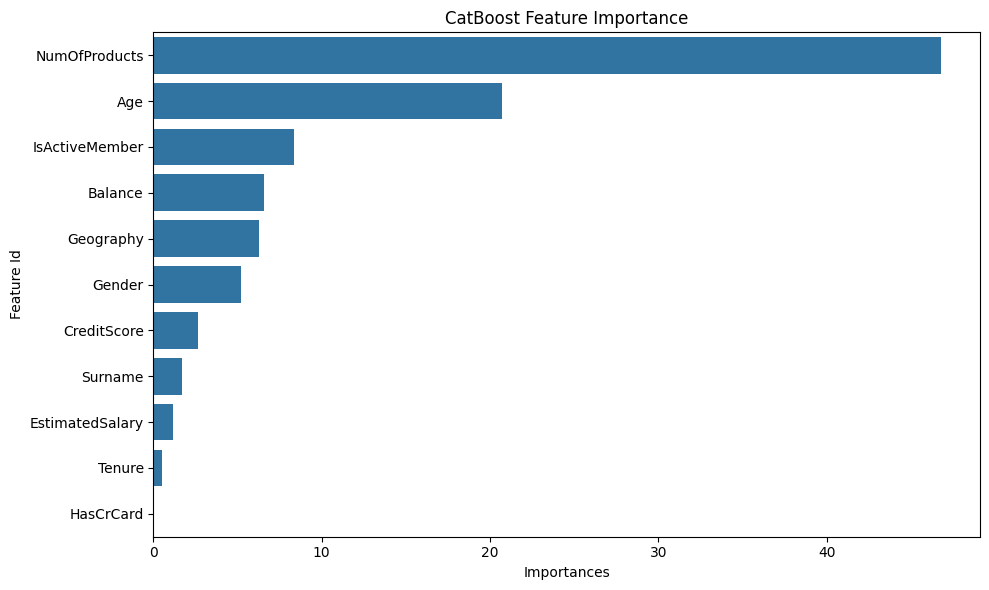

In [112]:
feat_importance = final_model.get_feature_importance(prettified=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feat_importance.sort_values('Importances', ascending=False))
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

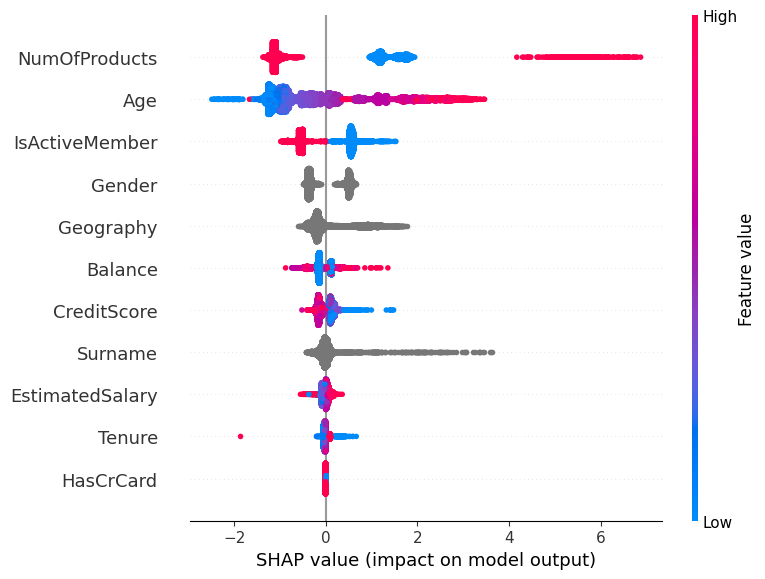

In [113]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

Сабмишн

In [114]:
submission = pd.DataFrame({
    'id': test['id'], 
    'Exited': y_test_pred
})

submission.to_csv('test_preds_2706_5.csv', index=False, sep=',')